<a href="https://colab.research.google.com/github/lindseyyu/cis107-dataset/blob/main/CIS107_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing initial libraries
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import argparse
import cv2

In [ ]:
import zipfile
import os

In [ ]:
!wget --no-check-certificate \
    "https://github.com/lindseyyu/cis107-dataset/archive/refs/heads/main.zip" \
    -O "/tmp/main.zip"


zip_ref = zipfile.ZipFile('/tmp/main.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/src') #Extracts the files into the /tmp folder
zip_ref.close()

--2022-05-05 04:29:55--  https://github.com/lindseyyu/cis107-dataset/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/lindseyyu/cis107-dataset/zip/refs/heads/main [following]
--2022-05-05 04:29:55--  https://codeload.github.com/lindseyyu/cis107-dataset/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/main.zip’

/tmp/main.zip           [        <=>         ]  37.14M  23.6MB/s    in 1.6s    

2022-05-05 04:29:57 (23.6 MB/s) - ‘/tmp/main.zip’ saved [38947959]



# Part 1: Calculating Image Features using CV

In [ ]:
files = [] #this will be used to store the file names 
color_val = [] # this will be used to store the colorfulness field 
num_contours = [] #storing number of contours 
pixel_contrast = [] #storing texture contrast 
pixel_dissimilar = [] #storing texture dissimilarity
pixel_homog = [] #storing texture homgeneity

## Feature 1: Colorfulness

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import imutils 
from pathlib import Path
import glob

%matplotlib inline

In [ ]:
#Function sourced from https://pyimagesearch.com/2017/06/05/computing-image-colorfulness-with-opencv-and-python/

def image_colorfulness(image):
	# split the image into its respective RGB components
	(B, G, R) = cv2.split(image.astype("float"))
	# compute rg = R - G
	rg = np.absolute(R - G)
	# compute yb = 0.5 * (R + G) - B
	yb = np.absolute(0.5 * (R + G) - B)
	# compute the mean and standard deviation of both `rg` and `yb`
	(rbMean, rbStd) = (np.mean(rg), np.std(rg))
	(ybMean, ybStd) = (np.mean(yb), np.std(yb))
	# combine the mean and standard deviations
	stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
	meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
	# derive the "colorfulness" metric and return it
	return stdRoot + (0.3 * meanRoot)

In [ ]:
# loop over the image paths
paths = ["/src/cis107-dataset-main/control/*.*", "/src/cis107-dataset-main/schizophrenia/*.*"]

results = [] #to visualize results 

#For each image, we append the file name with the associated colorfulness value      
for path in paths:
  for file in glob.glob(path):
    image = cv2.imread(file)
    image2 = imutils.resize(image, width=250)
    C = image_colorfulness(image2)
    cv2.putText(image2, "{:.2f}".format(C), (40, 40), 
		cv2.FONT_HERSHEY_SIMPLEX, 1.4, (0, 255, 0), 3)
    files.append(str(Path(file).with_suffix('')))
    color_val.append(C)
    results.append((image2, C))
    

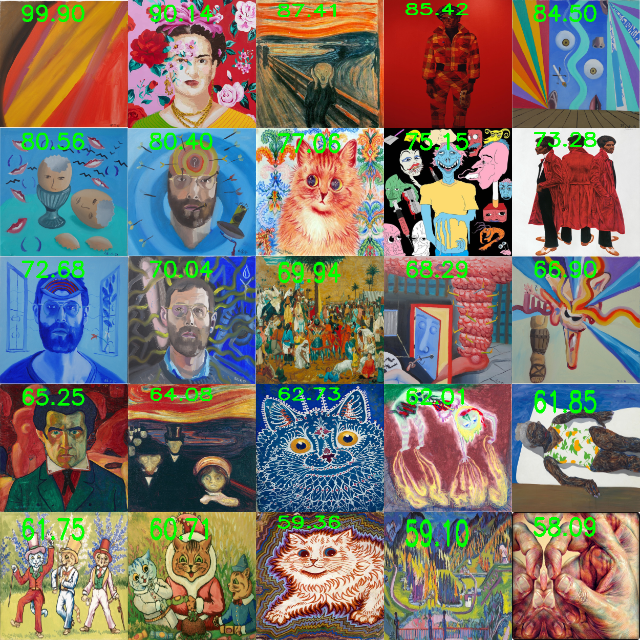

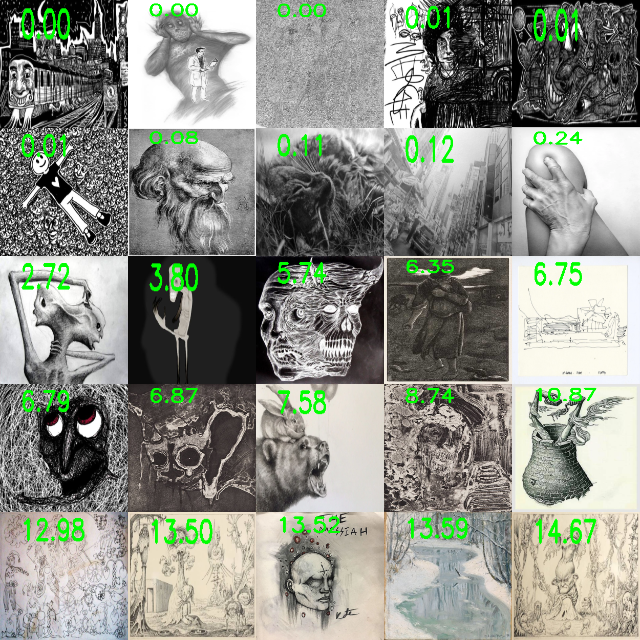

In [ ]:
from google.colab.patches import cv2_imshow
from imutils import build_montages

results = sorted(results, key=lambda x: x[1], reverse=True)
mostColor = [r[0] for r in results[:25]]
leastColor = [r[0] for r in results[-25:]][::-1]
mostColorMontage = build_montages(mostColor, (128, 128), (5, 5))
leastColorMontage = build_montages(leastColor, (128, 128), (5, 5))
cv2_imshow(mostColorMontage[0])
cv2_imshow(leastColorMontage[0])

## Feature 2: Objects / Number of Contours Detected

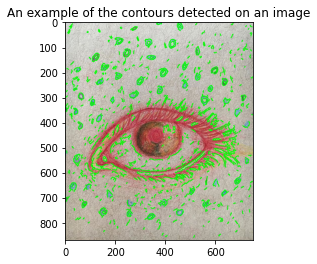

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for path in paths:
  for file in glob.glob(path):
    image = cv2.imread(file) #in BGR from imread

    #Convert to Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='gray')

    #Equalizing the grayscale to add more contrast
    adjusted = cv2.equalizeHist(gray)
    plt.imshow(adjusted)

    #Applying a Gaussian Blur
    blur = cv2.GaussianBlur(adjusted, (11, 11), 0)
    plt.imshow(blur, cmap='gray')

    #Function to find the min and max theshold for contours based on optimization using Canny
    def getAutoEdge(image, sigma=0.23):
      v = np.median(image)
      l = int(max(0, (1.0 - sigma) * v))
      u = int(min(255, (1.0 + sigma) * v))
      e = cv2.Canny(image, l, u)
      return e

    #FInding Contour Count
    dilated = cv2.dilate(getAutoEdge(blur), (1, 1), iterations=0)
    #plt.imshow(dilated, cmap='gray')
    (cnt, hierarchy) = cv2.findContours(
        dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    #Annotating an image with the contours for example
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.drawContours(rgb, cnt, -1, (0, 255, 0), 2)
    num_contours.append(len(cnt)) #Adding number of contours found 

    plt.title("An example of the contours detected on an image")
    plt.imshow(rgb) #Will show the last image with contours for an example

## Feature 3 and 4: Texure Contrast and Dissimilarity Averages from Gray Level Co-Occurence Matrix (GLCM)

In [ ]:
import skimage.feature as feature
from statistics import mean

for path in paths:
  for file in glob.glob(path):
    # Read in the images
    image = cv2.imread(file)
    #Change to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #Create the GLCM Matrix, pixel pairs are taken 50 apart from the following angles in radians
    graycom = feature.greycomatrix(gray, [50], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)

    #Take average contrast and dissimilarity across 4 neighbor pairs
    contrast = mean(feature.greycoprops(graycom, 'contrast')[0])
    dissimilarity = mean(feature.greycoprops(graycom, 'dissimilarity')[0])
    homog = mean(feature.greycoprops(graycom, 'homogeneity')[0])

    pixel_contrast.append(contrast)
    pixel_dissimilar.append(dissimilarity)
    pixel_homog.append(homog)

# Part 2: Combining and Analyzing Data

In [ ]:
data = {"name": files, "colorfulness": color_val, "contour_count": num_contours, "contrast": pixel_contrast, "dissimilarity": pixel_dissimilar, "homogeneity": pixel_homog}


In [ ]:
df = pd.DataFrame(data)

In [ ]:
df["schizophrenia"] = [1 if 'schizophrenia' in x else 0 for x in df['name']]

##I: Summary Statistics across Schizophrenic and Non-Schizoprenic Artists

In [ ]:
df.groupby("schizophrenia", as_index=False).mean()

,schizophrenia,colorfulness,contour_count,contrast,dissimilarity,homogeneity
0,0,37.122041,301.622222,2992.382207,33.949713,0.120249
1,1,37.718854,539.500000,4194.554010,41.124898,0.076589


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


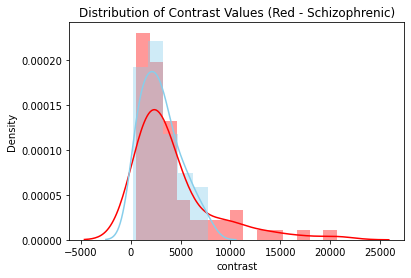

In [ ]:
import seaborn as sns
sns.distplot( df.loc[df['schizophrenia'] == 1]['contrast'] , color="red", label="Schizophrenic").set_title('Distribution of Contrast Values (Red - Schizophrenic)')
sns.distplot( df.loc[df['schizophrenia'] == 0]['contrast'] , color="skyblue", label="Non-Schizophrenic");


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


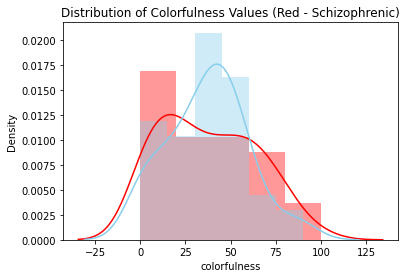

In [ ]:
sns.distplot( df.loc[df['schizophrenia'] == 1]['colorfulness'] , color="red", label="Schizophrenic").set_title('Distribution of Colorfulness Values (Red - Schizophrenic)')
sns.distplot( df.loc[df['schizophrenia'] == 0]['colorfulness'] , color="skyblue", label="Non-Schizophrenic");

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


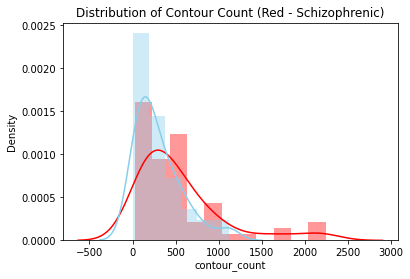

In [ ]:
sns.distplot( df.loc[df['schizophrenia'] == 1]['contour_count'] , color="red", label="Schizophrenic").set_title('Distribution of Contour Count (Red - Schizophrenic)')
sns.distplot( df.loc[df['schizophrenia'] == 0]['contour_count'] , color="skyblue", label="Non-Schizophrenic");

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


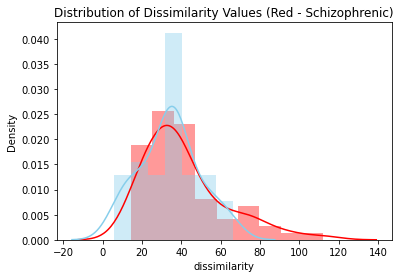

In [ ]:
sns.distplot( df.loc[df['schizophrenia'] == 1]['dissimilarity'] , color="red", label="Schizophrenic").set_title('Distribution of Dissimilarity Values (Red - Schizophrenic)')
sns.distplot( df.loc[df['schizophrenia'] == 0]['dissimilarity'] , color="skyblue", label="Non-Schizophrenic");

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


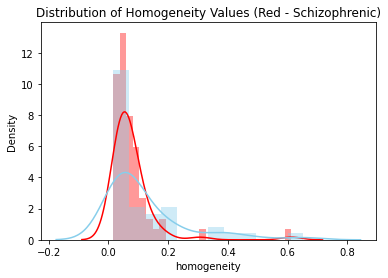

In [ ]:
sns.distplot( df.loc[df['schizophrenia'] == 1]['homogeneity'] , color="red", label="Schizophrenic").set_title('Distribution of Homogeneity Values (Red - Schizophrenic)')
sns.distplot( df.loc[df['schizophrenia'] == 0]['homogeneity'] , color="skyblue", label="Non-Schizophrenic");

## II: Logistic Regression on Fields to Indicate Schizophrenia

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, 1:6], df.iloc[:, 6:], test_size=0.3, random_state=42)

In [ ]:
x_train.shape, y_train.shape

((79, 5), (79, 1))

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()

classifier.fit(x_train, y_train.values.ravel())
weight = classifier.coef_  
weight

array([[ 0.00038023,  0.00182668,  0.00019667, -0.0222149 , -0.00073345]])

In [ ]:
predictions = classifier.predict(x_test)

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[ 2 12]
 [ 1 19]]


In [ ]:
score = classifier.score(x_test, y_test)
print(score)

0.6176470588235294


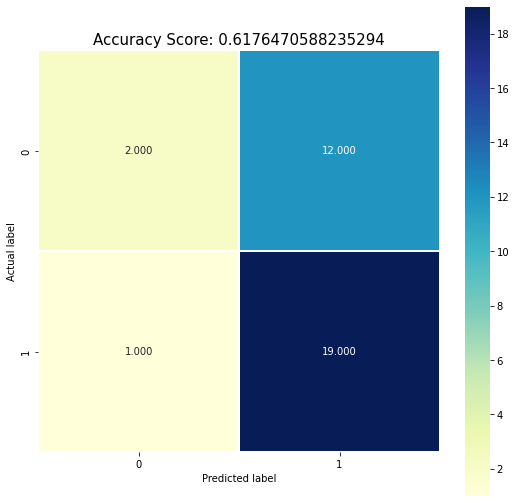

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, cmap = "YlGnBu", square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

## III: Time Series Evaluation, Bryan Charnley

In [ ]:
bryan_df = df[df['name'].str.contains('Charnley')]

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
bryan_df['date'] = bryan_df.apply(lambda x: x['name'].split(", ")[-1],axis=1)


In [ ]:
from datetime import datetime

bryan_df['date'] = pd.to_datetime(bryan_df['date'])


In [ ]:
bryan_df.set_index('date', inplace = True)

In [ ]:
bryan_df.drop(['name', 'schizophrenia'], axis=1, inplace=True)

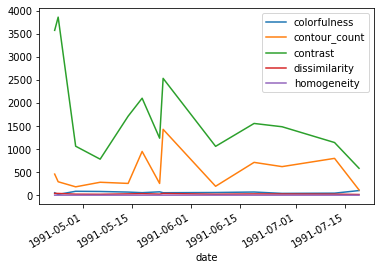

In [ ]:
bryan_df["1991-04-23":"1991-07-19"].plot();

In [ ]:
df.to_csv('../image/dataset.csv')